In [1]:
# numpy
import numpy as np
# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# scipy
import scipy as sp
import scipy.stats
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import dok_matrix
from scipy import linalg
# pandas
import pandas as pd
# netcdf
import netCDF4
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
# else
import timeit
import datetime as dt

In [2]:
# 기본적인 세팅
def pprint(arr):
    print("type : {}".format(type(arr)))
    print("shape : {}, dimension : {}, dtype : {}".format(arr.shape, arr.ndim, arr.dtype))
    print("Array Data : \n", arr)

print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
print ('설정 파일 위치: ', mpl.matplotlib_fname())
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# 해당 파일 목록 중 Nanum이 들어간 글꼴 경로 찾기
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

# path에 경로 적고 plt.rc로 폰트 설정
path = '/usr/share/fonts/nhn-nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=40).get_name()
print(font_name)
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False  # 그래프 안에 '-' 부호도 표시되도록 하는 함수

버전:  3.0.2
설치 위치:  /usr/lib64/python3.6/site-packages/matplotlib/__init__.py
설정 위치:  /home/leehaewon/.config/matplotlib
캐시 위치:  /home/leehaewon/.cache/matplotlib
설정 파일 위치:  /usr/lib64/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
NanumGothic


In [10]:
# netcdf 내부 정보 획득하는 함수 선언
'''
ncInfo는 불러온 nc파일의 dimensions(차원), variables(변수), attribute information(속성 정보)를 리턴한다.
@param
nc_obj : netcdf파일의 Dataset
verb : Boolean 값. 각 속성에 대한 출력 여부

@return
nc_attrs : list(global attributes)
nc_dims : list(dimensions)
nc_vars : list(variables)
'''
def ncInfo(nc_obj, verb=True):
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key
        @param
        key(unicode) : netcdf파일의 Dataset의 variables들의 key 
        """
        try:
            print("\t\ttype:", repr(nc_obj.variables[key].dtype))
            for ncattr in nc_obj.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_obj.variables[key].getncattr(ncattr)))
        except KeyError:    # 입력받은 키가 없는 경우
            print("WARNING: %s 해당 key인 attribute가 존재하지 않습니다." % key)

    # NetCDF global attributes
    nc_attrs = nc_obj.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_obj.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_obj.dimensions]  # dimensions
    # Dimension shape information
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim)
            print("\t\tsize:", len(nc_obj.dimensions[dim]))
            print_ncattr(dim)
    # Variable information
    nc_vars = [var for var in nc_obj.variables]  # variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_obj.variables[var].dimensions)
                print("\t\tsize:", nc_obj.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [11]:
# netcdf 파일 불러오기
dataset = Dataset('test2.nc')
print(dataset.file_format) 

NETCDF3_CLASSIC


In [12]:
# 각 variables의 data를 array로 가져오기
lats = dataset.variables['lat'][:] 
lons = dataset.variables['lon'][:]
time = dataset.variables['time'][:]
air = dataset.variables['air'][:]  # shape is time, lat, lon as shown above
print("lat variables 내 존재하는 값들")
print(lats)
print("---------------------------------------------------------------------------------")
print("lons variables 내 존재하는 값들")
print(lons)
print("---------------------------------------------------------------------------------")
print("time variables 내 존재하는 값들")
print(time)
print("---------------------------------------------------------------------------------")
print("air variables 내 존재하는 값들")
print(air)

lat variables 내 존재하는 값들
[ 90.   87.5  85.   82.5  80.   77.5  75.   72.5  70.   67.5  65.   62.5
  60.   57.5  55.   52.5  50.   47.5  45.   42.5  40.   37.5  35.   32.5
  30.   27.5  25.   22.5  20.   17.5  15.   12.5  10.    7.5   5.    2.5
   0.   -2.5  -5.   -7.5 -10.  -12.5 -15.  -17.5 -20.  -22.5 -25.  -27.5
 -30.  -32.5 -35.  -37.5 -40.  -42.5 -45.  -47.5 -50.  -52.5 -55.  -57.5
 -60.  -62.5 -65.  -67.5 -70.  -72.5 -75.  -77.5 -80.  -82.5 -85.  -87.5
 -90. ]
---------------------------------------------------------------------------------
lons variables 내 존재하는 값들
[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125.  127.5 130.  132.5 135.  137.5 140.  142.5 145.  147.5
 150.  152.5 155.  157.5 160.  162.5 165.  167.5 170.  172

In [13]:
# nc file의 'time' 분석
time_idx = 120                  # 저장된 time에 따라 정해진 기준 날로부터 일 수
offset = dt.timedelta(hours=48) # hours(시간)에 따라 지난 날짜와 시간 값을 알려줌
# nc file에 존재하는 모든 time 값들을 전부 년월일 데이터로 변환
dt_time = [dt.date(1, 1, 1) + dt.timedelta(hours=t) - offset\
           for t in time]
cur_time = dt_time[time_idx] # time_idx에 따른 지정 년도의 년월일 데이터
print(offset)
print("-------------------------------------------")
for val in dt_time:
    print(val, "\n")
print("-------------------------------------------")
print(cur_time)

2 days, 0:00:00
-------------------------------------------
2012-01-01 

2012-01-02 

2012-01-03 

2012-01-04 

2012-01-05 

2012-01-06 

2012-01-07 

2012-01-08 

2012-01-09 

2012-01-10 

2012-01-11 

2012-01-12 

2012-01-13 

2012-01-14 

2012-01-15 

2012-01-16 

2012-01-17 

2012-01-18 

2012-01-19 

2012-01-20 

2012-01-21 

2012-01-22 

2012-01-23 

2012-01-24 

2012-01-25 

2012-01-26 

2012-01-27 

2012-01-28 

2012-01-29 

2012-01-30 

2012-01-31 

2012-02-01 

2012-02-02 

2012-02-03 

2012-02-04 

2012-02-05 

2012-02-06 

2012-02-07 

2012-02-08 

2012-02-09 

2012-02-10 

2012-02-11 

2012-02-12 

2012-02-13 

2012-02-14 

2012-02-15 

2012-02-16 

2012-02-17 

2012-02-18 

2012-02-19 

2012-02-20 

2012-02-21 

2012-02-22 

2012-02-23 

2012-02-24 

2012-02-25 

2012-02-26 

2012-02-27 

2012-02-28 

2012-02-29 

2012-03-01 

2012-03-02 

2012-03-03 

2012-03-04 

2012-03-05 

2012-03-06 

2012-03-07 

2012-03-08 

2012-03-09 

2012-03-10 

2012-03-11 

2012-03-12 

2012

NameError: name 'addcyclic' is not defined

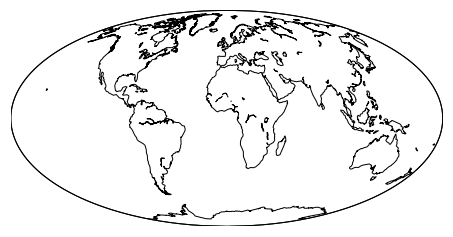

In [14]:
# matplotlib으로 위에 지정한 날짜의 전세계 온도에 대한 plot 진행
fig = plt.figure()
fig.subplots_adjust(left=0., right=1., bottom=0., top=0.9)
# Setup the map. See http://matplotlib.org/basemap/users/mapsetup.html
# for other projections.
m = Basemap(projection='moll', llcrnrlat=-90, urcrnrlat=90,\
            llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=0)
m.drawcoastlines()
m.drawmapboundary()
# Make the plot continuous
air_cyclic, lons_cyclic = addcyclic(air[time_idx, :, :], lons)
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
air_cyclic, lons_cyclic = shiftgrid(180., air_cyclic, lons_cyclic, start=False)
# Create 2D lat/lon arrays for Basemap
lon2d, lat2d = np.meshgrid(lons_cyclic, lats)
# Transforms lat/lon into plotting coordinates for projection
x, y = m(lon2d, lat2d)
# Plot of air temperature with 11 contour intervals
cs = m.contourf(x, y, air_cyclic, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label("%s (%s)" % (nc_fid.variables['air'].var_desc,\
                            nc_fid.variables['air'].units))
plt.title("%s on %s" % (nc_fid.variables['air'].var_desc, cur_time))

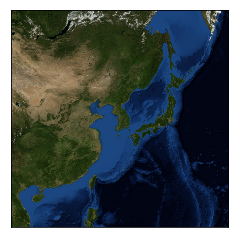

In [16]:
m = Basemap(width=5000000,height=5000000,projection='lcc',     # width, height는 말 그대로 map의 크기
            resolution=None,lat_0=37,lon_0=127.)   # lat 은 위도(가로선), lon은 경도(세로선)
m.bluemarble()
#m.drawcoastlines()
#m.drawcountries()
plt.show()

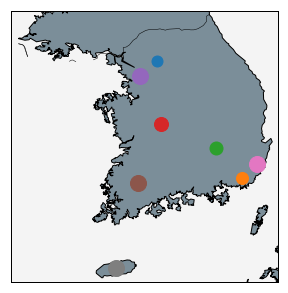

In [ ]:
# Set iPython to display visualization inline

%matplotlib inline

# %% Location data 

# seoul: 37.5650172,126.8494674

# pusan: 35.1644298,129.0017604

# daegu: 35.8797297,128.4966604

# daegeon: 36.3730796,127.3187604



# Incheon: 37.4645293,126.6043104

# gwangju: 35.1766798,126.7737604

# ulsan: 35.5620297,129.2814604

# JeJu: 33.5038451,126.4949806

seoul = {'lat': [37.5650172+0.1], 'lon': [126.8494674 + 0.5]}

pusan = {'lat': [35.1644298+0.1], 'lon': [129.0017604]}

daegu = {'lat': [35.8797297], 'lon': [128.4966604]}

daegeon = {'lat': [36.3730796], 'lon': [127.3187604 + 0.1]}



Incheon = {'lat': [37.4645293 - 0.1], 'lon': [126.6043104 + 0.4]}

gwangju = {'lat': [35.1766798], 'lon': [126.7737604 + 0.2]}

ulsan = {'lat': [35.5620297], 'lon': [129.2814604]}

JeJu = {'lat': [33.5038451 - 0.1], 'lon': [126.4949806+0.05]}



data = {'lat': [37.5650172, 

                35.1644298, 

                35.8797297, 

                36.3730796,

                

                (37.4645293-0.1), 

                35.1766798, 

                35.5620297, 

                (33.5038451-0.1)], 

        'lon': [(126.8494674+0.5), 129.0017604, 128.4966604,(127.3187604+0.1),

                (126.6043104+0.3), (126.7737604+0.2), 129.2814604, 126.4949806]}





data = pd.DataFrame(data) 



# %

# Create a figure of size (i.e. pretty big)

fig = plt.figure(figsize=(5, 5))



# Create a map, using the Gall–Peters projection, 

map = Basemap(projection='gall',

              # Projection:

                  # gall

                  # cyl

                  # aeqd'

              

              llcrnrlon = 124.5,            # left longitude

              urcrnrlon = 129.7,            # right longitude

              urcrnrlat = 38.7,              # upper latitude

              llcrnrlat = 33.1,                # lower latitude

              

#              llcrnrlon = 124,              # lower-left corner longitude

#              llcrnrlat = 0,               # lower-left corner latitude

#              urcrnrlon = 45,               # upper-right corner longitude

#              urcrnrlat = 73,               # upper-right corner latitude

              

              # resolution: 

                  # The resolution of he included coastlines, lakes, and so on. 

                  # The options are 

                      # c (crude, the default), l (low), i (intermediate), 

                      # h (high), f (full) or None.

              resolution = 'i', 

              # area_thresh: 

                  # The threshold under what no coast line or lake will be drawn. 

                  # Default 10000,1000,100,10,1 for

              area_thresh = 100)





# Draw the coastlines on the map

map.drawcoastlines()



# Draw country borders on the map

map.drawcountries()



# Fill the land with grey

#map.fillcontinents(color = '#888888')

map.fillcontinents(color='#7b8e99', lake_color='#FFFFFF')

# Draw the map boundaries

map.drawmapboundary(fill_color='#f4f4f4')

#map.drawmapboundary(fill_color='#FFFFFF')



# Define our longitude and latitude points

# We have to use .values because of a wierd bug when passing pandas data

# to basemap.

x, y = map(seoul['lon'], seoul['lat'])

map.plot(x, y, 'o', markersize = 11) # markersize 



x, y = map(pusan['lon'], pusan['lat'])

map.plot(x, y, 'o', markersize = 12) # markersize 



x, y = map(daegu['lon'], daegu['lat'])

map.plot(x, y, 'o', markersize = 13) # markersize 



x, y = map(daegeon['lon'], daegeon['lat'])

map.plot(x, y, 'o', markersize = 14) # markersize 





x, y = map(Incheon['lon'], Incheon['lat'])

map.plot(x, y, 'o', markersize = 16) # markersize 



x, y = map(gwangju['lon'], gwangju['lat'])

map.plot(x, y, 'o', markersize = 16) # markersize 



x, y = map(ulsan['lon'], ulsan['lat'])

map.plot(x, y, 'o', markersize = 16) # markersize 



x, y = map(JeJu['lon'], JeJu['lat'])

map.plot(x, y, 'o', markersize = 16) # markersize 





# Show the map

plt.show()